In [30]:
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

### Set session info and path

In [18]:
animal_name='JC315'
date='20240406'

basedir = "/mnt/adata11/"
mbasedir="/adata_pool/merged/"+animal_name+'-'+date+'/'

basename = animal_name+'-'+date

### Import metadata

In [19]:
session_metadata = {}
with open('session_metadata.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file, delimiter=";")    
    for line in reader:
        session_id = line.pop('session_id')
        session_metadata[session_id] = line
        
print('Metadata for',basename)
session_metadata[basename]

Metadata for JC315-20240406


{'num_tetr': '32',
 'last_pfc_left': '8',
 'last_pfc_right': '16',
 'session_names': "['presleep','training1','intersleep','training2','postsleep']",
 'session_idx': '[[1],[2],[3,4,5],[6],[7]]',
 'reward_arms': '7,2',
 'rewards': 'C,S'}

### Set sampling rate and adjust imported metadata

In [40]:
sampling_rate_res_old=24000
sampling_rate_res=20000
sampling_rate_eeg=1250
downsampled_res=sampling_rate_res/sampling_rate_res_old

num_tetrodes = int(session_metadata[basename]['num_tetr'])
session_names = eval(session_metadata[basename]['session_names'])
num_channels = 128

### Import and merge swr files

In [21]:
sw_merged = []

for ii in range(len(session_names)):
    sw_file = np.loadtxt(mbasedir+basename+'_'+session_names[ii]+'.sw',dtype=int)
    sw_merged.append(sw_file)
    
sw_merged = np.vstack(sw_merged)

### Import template parameter file

In [22]:
with open(mbasedir+'TEMPLATE.par', 'r') as file:
    template = [list(map(lambda x: int(x.rstrip('.')), line.split())) for line in file] # to avoid parsing issue with trailing period

### Import and merge eeg files

In [23]:
def find_files_with_eeg(directory):
    eeg_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.eeg'):
                eeg_files.append(os.path.join(root, file))
                
    return eeg_files

In [24]:
eeg_files=sorted(find_files_with_eeg(mbasedir))

In [25]:
eeg_merged=np.fromfile(eeg_files[0], dtype=np.int16)
print('Reshaping',eeg_files[0],'from length',eeg_merged.shape)
eeg_merged= eeg_merged.reshape(int(len(eeg_merged)/num_channels),num_channels)
print('New eeg_merged shape:',eeg_merged.shape)

Reshaping /adata_pool/merged/JC315-20240406/JC315-20240406_intersleep.eeg from length (573687936,)
New eeg_merged shape: (4481937, 128)


### Filter the eeg

In [ ]:
bandpass_low = 150
bandpass_high = 350

In [42]:
def butter_bandpass(bandpass_low, bandpass_high, sampling_rate, order=5):
    nyquist = 0.5 * sampling_rate
    low = bandpass_low / nyquist
    high = bandpass_high / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [49]:
b, a = butter_bandpass(bandpass_low, bandpass_high, sampling_rate_eeg)
eeg_filtered = np.empty_like(eeg_merged)
for ii in range(eeg_merged.shape[1]):
    eeg_filtered[:,ii] = filtfilt(b, a, eeg_merged[:, ii])

In [51]:
eeg_filtered

array([[   2,    1,    2, ...,   -1,   -1,   -1],
       [ -63, -107,  -10, ...,  108,   31,   75],
       [-140, -123,  -53, ...,  -34, -115,  -35],
       ...,
       [-238, -126, -263, ..., -302, -376, -256],
       [-260, -100, -233, ..., -438, -490, -408],
       [ -47,   -6,   -2, ...,    0,    0,    0]], dtype=int16)

### Load the session timestamps and downsample them

In [54]:
session_timestamps=np.loadtxt(basedir+"processing/"+animal_name+'/'+date+'/'+'session_shifts.txt')

session_timestamps=np.append([0],session_timestamps) # start the first timestamp at 0
session_timestamps_down=session_timestamps*downsampled_res
print('Resampled session timestamps:',session_timestamps_down)

Resampled session timestamps: [0.00000000e+00 7.20001225e+07 1.17216620e+08 1.55038118e+08
 1.55875740e+08 1.88927612e+08 2.32498860e+08 3.04498982e+08]


In [55]:
print('eeg_filtered shape:',eeg_filtered.shape)
print('sw_merged shape:',sw_merged.shape)

eeg_filtered shape: (4481937, 128)
sw_merged shape: (6925, 3)


## Choose and plot a SWR event

Channels for tetrode 28: [36, 37, 38, 39]
SWR peak timestamp: 3362006


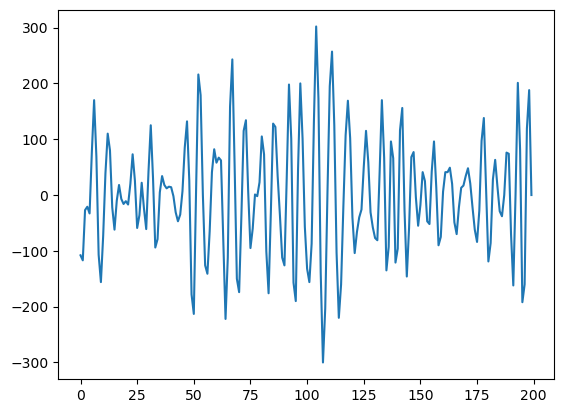

In [63]:
tetrode_par = 28

tetrode_par_idx = template[tetrode_par+3]
channels = tetrode_par_idx[1:]
print(f'Channels for tetrode {tetrode_par}:', channels)

sw_idx = 700
sw_peak = sw_merged[sw_idx,1]
print('SWR peak timestamp:',sw_peak)
step_size = 100 # 50 corresponds to 40 ms at a 1.25 kHz sampling rate

plt.plot(eeg_filtered[sw_peak-step_size:sw_peak+step_size,channels[0]])